### DATES IMAGE CLASSIFIFCATION 

In [1]:
#importing important libraries 
# Imports
#not all used
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.utils import img_to_array,  load_img
import matplotlib.pyplot as plt
from PIL import Image 
from glob import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/open.zip"

Archive:  /content/drive/MyDrive/open.zip
   creating: open/
   creating: open/bumaan/
  inflating: open/bumaan/100_o.jpg   
  inflating: open/bumaan/101_o.jpg   
  inflating: open/bumaan/102_o.jpg   
  inflating: open/bumaan/103_o.jpg   
  inflating: open/bumaan/104_o.jpg   
  inflating: open/bumaan/105_o.jpg   
  inflating: open/bumaan/106_o.jpg   
  inflating: open/bumaan/107_o.jpg   
  inflating: open/bumaan/108_o.jpg   
  inflating: open/bumaan/109_o.jpg   
  inflating: open/bumaan/10_o.jpg    
  inflating: open/bumaan/110_o.jpg   
  inflating: open/bumaan/111_o.jpg   
  inflating: open/bumaan/112_o.jpg   
  inflating: open/bumaan/113_o.jpg   
  inflating: open/bumaan/114_o.jpg   
  inflating: open/bumaan/115_o.jpg   
  inflating: open/bumaan/116_o.jpg   
  inflating: open/bumaan/117_o.jpg   
  inflating: open/bumaan/118_o.jpg   
  inflating: open/bumaan/119_o.jpg   
  inflating: open/bumaan/11_o.jpg    
  inflating: open/bumaan/120_o.jpg   
  inflating: open/bumaan/121_o.jpg   
 

In [4]:
import pathlib
data_dir = pathlib.Path('/content/open') # make a directory "data_dir"/content/drive/MyDrive/DatesImages/DatesImages
path = Path(data_dir)
path.ls() #list all the folders of dates images.
path

Path('/content/open')

In [5]:
def number_of_images_in_dataset(dataset):
  images = list(dataset.glob("*/*.*"))
  return len(images)
print("number of all images in dataset: {}".format(number_of_images_in_dataset(data_dir)))

number of all images in dataset: 1000



# Visualization

In [6]:
# class_names=['bumaan', 'fardh', 'khalas', 'lulu', 'shishi']
num_class = 5

print( num_class)

5


In [7]:
import tensorflow as tf
batch_size = 128 #The batch size defines the number of samples that will be propagated through the network 
img_height = 256
img_width = 256

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  class_names=['bumaan', 'fardh', 'khalas', 'lulu', 'shishi'],
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  class_names=['bumaan', 'fardh', 'khalas', 'lulu', 'shishi'],
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



print("Label names:", class_names)
print("Image dimensions:", img_width, "x", img_height)
num_class = len(class_names)
print(" number of classes", num_class)
#You will use 80% of the images for training and 20% for validation.

Found 1000 files belonging to 5 classes.
Using 800 files for training.
Found 1000 files belonging to 5 classes.
Using 200 files for validation.
Label names: ['bumaan', 'fardh', 'khalas', 'lulu', 'shishi']
Image dimensions: 256 x 256
 number of classes 5


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# TRAIN MODEL

### RESNET50

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model
pretrained_model=ResNet50(input_shape = (256, 256, 3), 
                        include_top = False, 
                        weights = 'imagenet')

for layer in pretrained_model.layers:
     layer.trainable = False

# pretrained_model.summary()
last_layer = pretrained_model.get_layer('conv5_block3_out')
print('last layer of resnet : output shape: ', last_layer.output_shape)
last_output= last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(5, activation='softmax') (x)       

model_rn = Model(pretrained_model.input, x) 


from tensorflow.keras.optimizers import RMSprop
model_rn.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])


94765736/94765736 [==============================] - 5s 0us/step
last layer of resnet : output shape:  (None, 8, 8, 2048)


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [10]:
model_rn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)

In [12]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 9e-1:
            self.model.stop_training = True

In [13]:
callback = CustomCallback()
history = model_rn.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[monitor],
  verbose=2,
  epochs = 10
)


Epoch 1/10
7/7 - 59s - loss: 283.1015 - accuracy: 0.2212 - val_loss: 83.9414 - val_accuracy: 0.3750 - 59s/epoch - 8s/step
Epoch 2/10
7/7 - 4s - loss: 54.0792 - accuracy: 0.6388 - val_loss: 15.0554 - val_accuracy: 0.8150 - 4s/epoch - 578ms/step
Epoch 3/10
7/7 - 4s - loss: 16.0820 - accuracy: 0.7788 - val_loss: 9.1005 - val_accuracy: 0.8250 - 4s/epoch - 564ms/step
Epoch 4/10
7/7 - 4s - loss: 4.5051 - accuracy: 0.8712 - val_loss: 3.1055 - val_accuracy: 0.8800 - 4s/epoch - 570ms/step
Epoch 5/10
7/7 - 4s - loss: 2.0630 - accuracy: 0.9200 - val_loss: 2.7852 - val_accuracy: 0.9250 - 4s/epoch - 566ms/step
Epoch 6/10
7/7 - 4s - loss: 1.0522 - accuracy: 0.9638 - val_loss: 3.5648 - val_accuracy: 0.9100 - 4s/epoch - 508ms/step
Epoch 7/10
7/7 - 4s - loss: 0.5967 - accuracy: 0.9737 - val_loss: 2.2012 - val_accuracy: 0.9250 - 4s/epoch - 571ms/step
Epoch 8/10
7/7 - 4s - loss: 0.3233 - accuracy: 0.9812 - val_loss: 2.6044 - val_accuracy: 0.9150 - 4s/epoch - 507ms/step
Epoch 9/10
7/7 - 4s - loss: 0.2069 

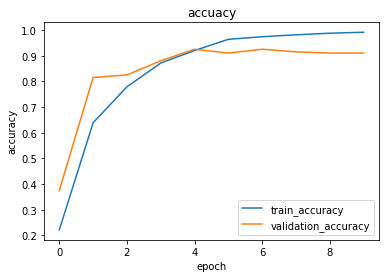

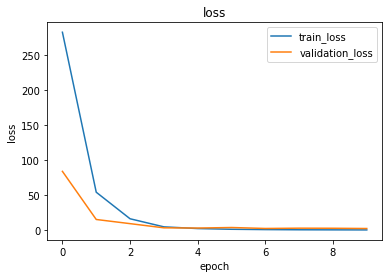

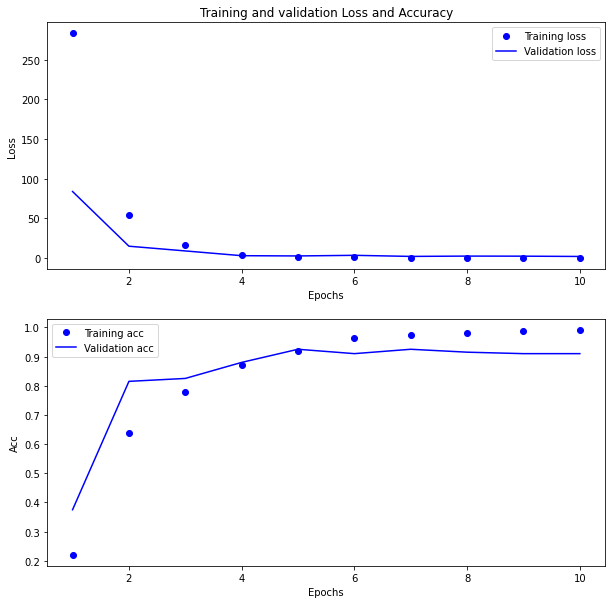

In [14]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()
plot_accuracy(history,'accuacy')
plot_loss(history, 'loss')

# Training curves
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [15]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
y_prediction = model_rn.predict(val_ds)
y_prediction = np.argmax (y_prediction, axis = 1)
labels =  []
for x, y in val_ds:
  for i in y.numpy():
   labels.append(i)
from sklearn.metrics import classification_report
y_test = np.array(labels)
print(confusion_matrix(y_test, y_prediction ))
print(classification_report(y_test, y_prediction))

2/2 [==============================] - 1s 460ms/step
[[42  0  0  1  0]
 [ 0 39  0  1  1]
 [ 3  2 42  0  0]
 [ 0  0  4 26  0]
 [ 4  2  0  0 33]]
              precision    recall  f1-score   support

           0       0.86      0.98      0.91        43
           1       0.91      0.95      0.93        41
           2       0.91      0.89      0.90        47
           3       0.93      0.87      0.90        30
           4       0.97      0.85      0.90        39

    accuracy                           0.91       200
   macro avg       0.92      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200



In [16]:
tf.keras.models.save_model(model_rn,'my_model3.hdf5')

# Evaluation

In [17]:
!pip install image-quality

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.6/146.6 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.6/170.6 KB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp38-cp38-linux_x86_64.whl size=233370 sha256=b86aefcf5daa2f9afeab33276ea136e164344d84c51ea14ca3c9007603df86ed
  Stored in directory: /root/.cache/pip/wheels/41/00/e7/b328c0f5e4bbb9ac8ba5a72e56b1749be63dc1ab1c9321fd4e
Successfully built libsvm


### Quality and Categorization

In [18]:
import random
from random import shuffle 
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.keras.utils.data_utils import Sequence


In [19]:
from tensorflow.keras.models import Model



def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

In [20]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    return cam_path
    
preprocess_input = tf.keras.applications.resnet50.preprocess_input
decode_predictions = tf.keras.applications.resnet50.decode_predictions

last_conv_layer_name = "conv5_block3_out"
img_size = (256, 256)

# Remove last layer's softmax
model_rn.layers[-1].activation = None

1/1 [==============================] - 1s 1s/step
This image most likely belongs to lulu.


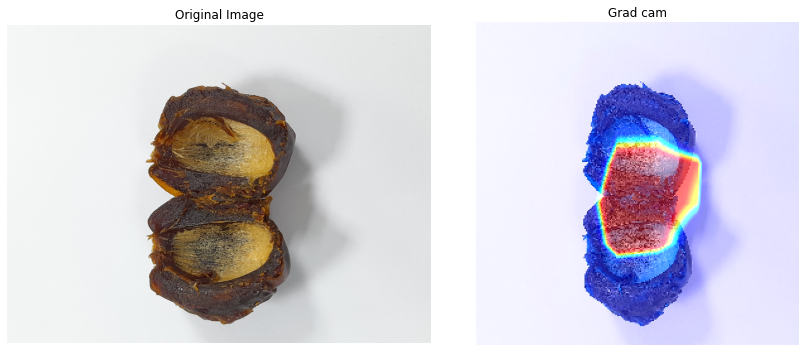

In [21]:
import imquality.brisque as brisque
import PIL.Image
img_path = "/content/open/lulu/19_o.jpg"
img = tf.keras.utils.load_img(
       img_path, target_size=(256, 256, 3)
)
img_array1 = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array1, 0) # Create a batch\n"
predictions = model_rn.predict(img_array)
# score = tf.nn.softmax(predictions[0])
print(
        "This image most likely belongs to {}."
            .format(class_names[np.argmax(predictions)])
        )

layer_name = 'conv5_block3_out'
grad_cam=GradCam(model_rn,np.expand_dims(img_array1, axis=0),layer_name)
grad_cam_superimposed = superimpose(img_array1, grad_cam, 0.8, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(plt.imread(img_path))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow((grad_cam_superimposed))
plt.axis('off')
plt.title('Grad cam')
plt.tight_layout()

1/1 [==============================] - 0s 24ms/step
This image most likely belongs to lulu.


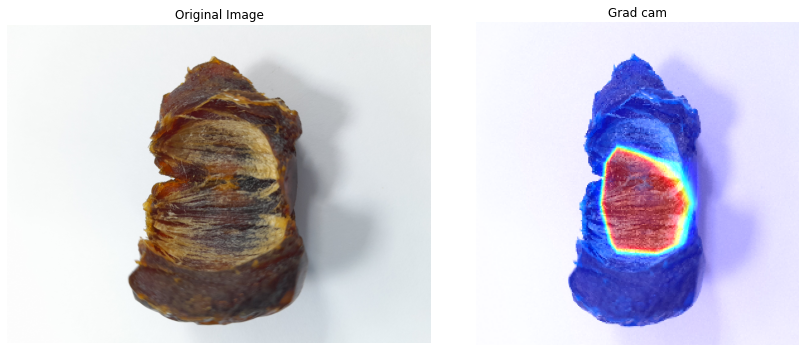

In [23]:
import imquality.brisque as brisque
import PIL.Image
img_path = "/content/open/lulu/10_o.jpg"
img = tf.keras.utils.load_img(
       img_path, target_size=(256, 256, 3)
)
img_array1 = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array1, 0) # Create a batch\n"
predictions = model_rn.predict(img_array)
# score = tf.nn.softmax(predictions[0])
print(
        "This image most likely belongs to {}."
            .format(class_names[np.argmax(predictions)])
        )

layer_name = 'conv5_block3_out'
grad_cam=GradCam(model_rn,np.expand_dims(img_array1, axis=0),layer_name)
grad_cam_superimposed = superimpose(img_array1, grad_cam, 0.8, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(plt.imread(img_path))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow((grad_cam_superimposed))
plt.axis('off')
plt.title('Grad cam')
plt.tight_layout()

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to shishi.


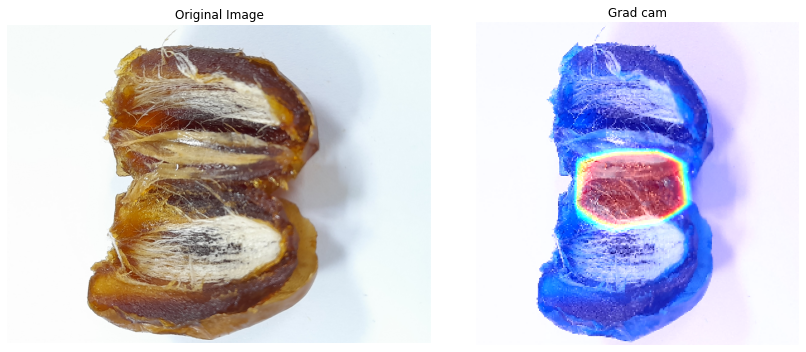

In [24]:
import imquality.brisque as brisque
import PIL.Image
img_path = "/content/open/shishi/19_o.jpg"
img = tf.keras.utils.load_img(
       img_path, target_size=(256, 256, 3)
)
img_array1 = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array1, 0) # Create a batch\n"
predictions = model_rn.predict(img_array)
# score = tf.nn.softmax(predictions[0])
print(
        "This image most likely belongs to {}."
            .format(class_names[np.argmax(predictions)])
        )

layer_name = 'conv5_block3_out'
grad_cam=GradCam(model_rn,np.expand_dims(img_array1, axis=0),layer_name)
grad_cam_superimposed = superimpose(img_array1, grad_cam, 0.8, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(plt.imread(img_path))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow((grad_cam_superimposed))
plt.axis('off')
plt.title('Grad cam')
plt.tight_layout()

1/1 [==============================] - 0s 21ms/step
This image most likely belongs to fardh.


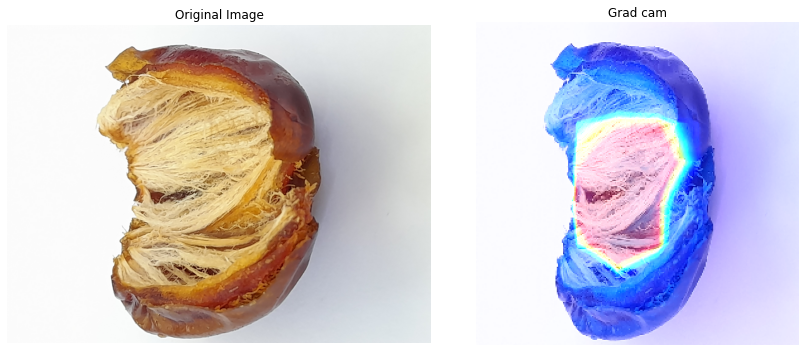

In [25]:
import imquality.brisque as brisque
import PIL.Image
img_path = "/content/open/fardh/19_o.jpg"
img = tf.keras.utils.load_img(
       img_path, target_size=(256, 256, 3)
)
img_array1 = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array1, 0) # Create a batch\n"
predictions = model_rn.predict(img_array)
# score = tf.nn.softmax(predictions[0])
print(
        "This image most likely belongs to {}."
            .format(class_names[np.argmax(predictions)])
        )

layer_name = 'conv5_block3_out'
grad_cam=GradCam(model_rn,np.expand_dims(img_array1, axis=0),layer_name)
grad_cam_superimposed = superimpose(img_array1, grad_cam, 0.8, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(plt.imread(img_path))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow((grad_cam_superimposed))
plt.axis('off')
plt.title('Grad cam')
plt.tight_layout()

1/1 [==============================] - 0s 21ms/step
This image most likely belongs to khalas.


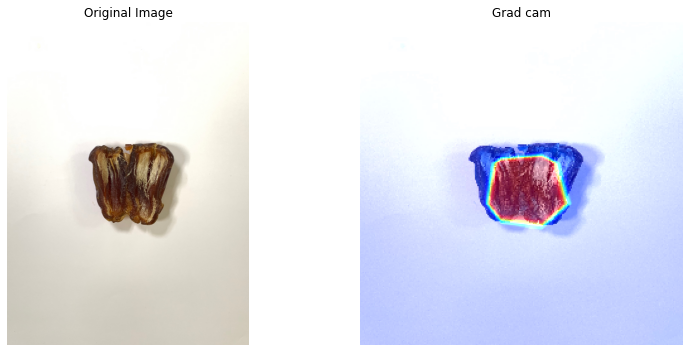

In [26]:
import imquality.brisque as brisque
import PIL.Image
img_path = "/content/open/khalas/19_o.jpg"
img = tf.keras.utils.load_img(
       img_path, target_size=(256, 256, 3)
)
img_array1 = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array1, 0) # Create a batch\n"
predictions = model_rn.predict(img_array)
# score = tf.nn.softmax(predictions[0])
print(
        "This image most likely belongs to {}."
            .format(class_names[np.argmax(predictions)])
        )

layer_name = 'conv5_block3_out'
grad_cam=GradCam(model_rn,np.expand_dims(img_array1, axis=0),layer_name)
grad_cam_superimposed = superimpose(img_array1, grad_cam, 0.8, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(plt.imread(img_path))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow((grad_cam_superimposed))
plt.axis('off')
plt.title('Grad cam')
plt.tight_layout()

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to khalas.


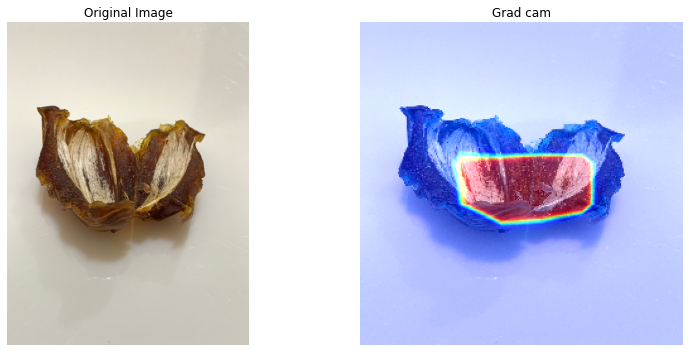

In [27]:
import imquality.brisque as brisque
import PIL.Image
img_path = "/content/open/khalas/100_o.jpg"
img = tf.keras.utils.load_img(
       img_path, target_size=(256, 256, 3)
)
img_array1 = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array1, 0) # Create a batch\n"
predictions = model_rn.predict(img_array)
# score = tf.nn.softmax(predictions[0])
print(
        "This image most likely belongs to {}."
            .format(class_names[np.argmax(predictions)])
        )

layer_name = 'conv5_block3_out'
grad_cam=GradCam(model_rn,np.expand_dims(img_array1, axis=0),layer_name)
grad_cam_superimposed = superimpose(img_array1, grad_cam, 0.8, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(plt.imread(img_path))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow((grad_cam_superimposed))
plt.axis('off')
plt.title('Grad cam')
plt.tight_layout()

1/1 [==============================] - 0s 30ms/step
This image most likely belongs to bumaan.


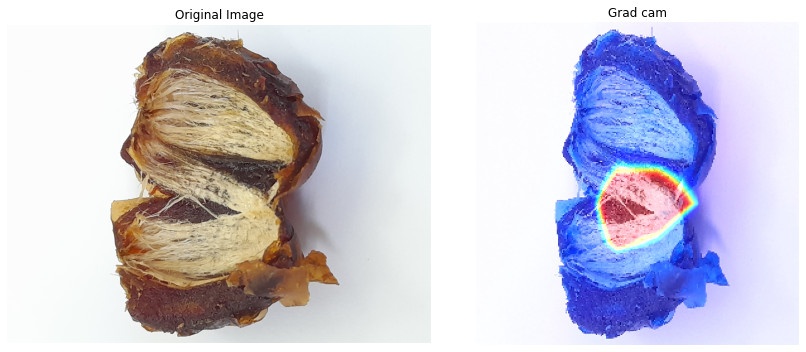

In [28]:
import imquality.brisque as brisque
import PIL.Image
img_path = "/content/open/bumaan/19_o.jpg"
img = tf.keras.utils.load_img(
       img_path, target_size=(256, 256, 3)
)
img_array1 = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array1, 0) # Create a batch\n"
predictions = model_rn.predict(img_array)
# score = tf.nn.softmax(predictions[0])
print(
        "This image most likely belongs to {}."
            .format(class_names[np.argmax(predictions)])
        )

layer_name = 'conv5_block3_out'
grad_cam=GradCam(model_rn,np.expand_dims(img_array1, axis=0),layer_name)
grad_cam_superimposed = superimpose(img_array1, grad_cam, 0.8, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(plt.imread(img_path))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow((grad_cam_superimposed))
plt.axis('off')
plt.title('Grad cam')
plt.tight_layout()

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to fardh.


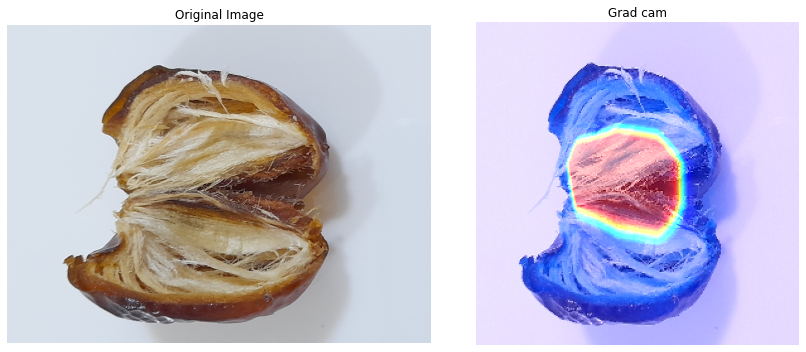

In [29]:
import imquality.brisque as brisque
import PIL.Image
img_path = "/content/open/fardh/60_o.jpg"
img = tf.keras.utils.load_img(
       img_path, target_size=(256, 256, 3)
)
img_array1 = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array1, 0) # Create a batch\n"
predictions = model_rn.predict(img_array)
# score = tf.nn.softmax(predictions[0])
print(
        "This image most likely belongs to {}."
            .format(class_names[np.argmax(predictions)])
        )

layer_name = 'conv5_block3_out'
grad_cam=GradCam(model_rn,np.expand_dims(img_array1, axis=0),layer_name)
grad_cam_superimposed = superimpose(img_array1, grad_cam, 0.8, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(plt.imread(img_path))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow((grad_cam_superimposed))
plt.axis('off')
plt.title('Grad cam')
plt.tight_layout()